# Deterministic Full Waveform Inversion

Min velocity: 1010.00  Max velocity 4500.00
dz,dx,dt (m): 4.04 4.04 0.0005713422791987305
Model dimension [nz,nx,nt]:  101 301 1000


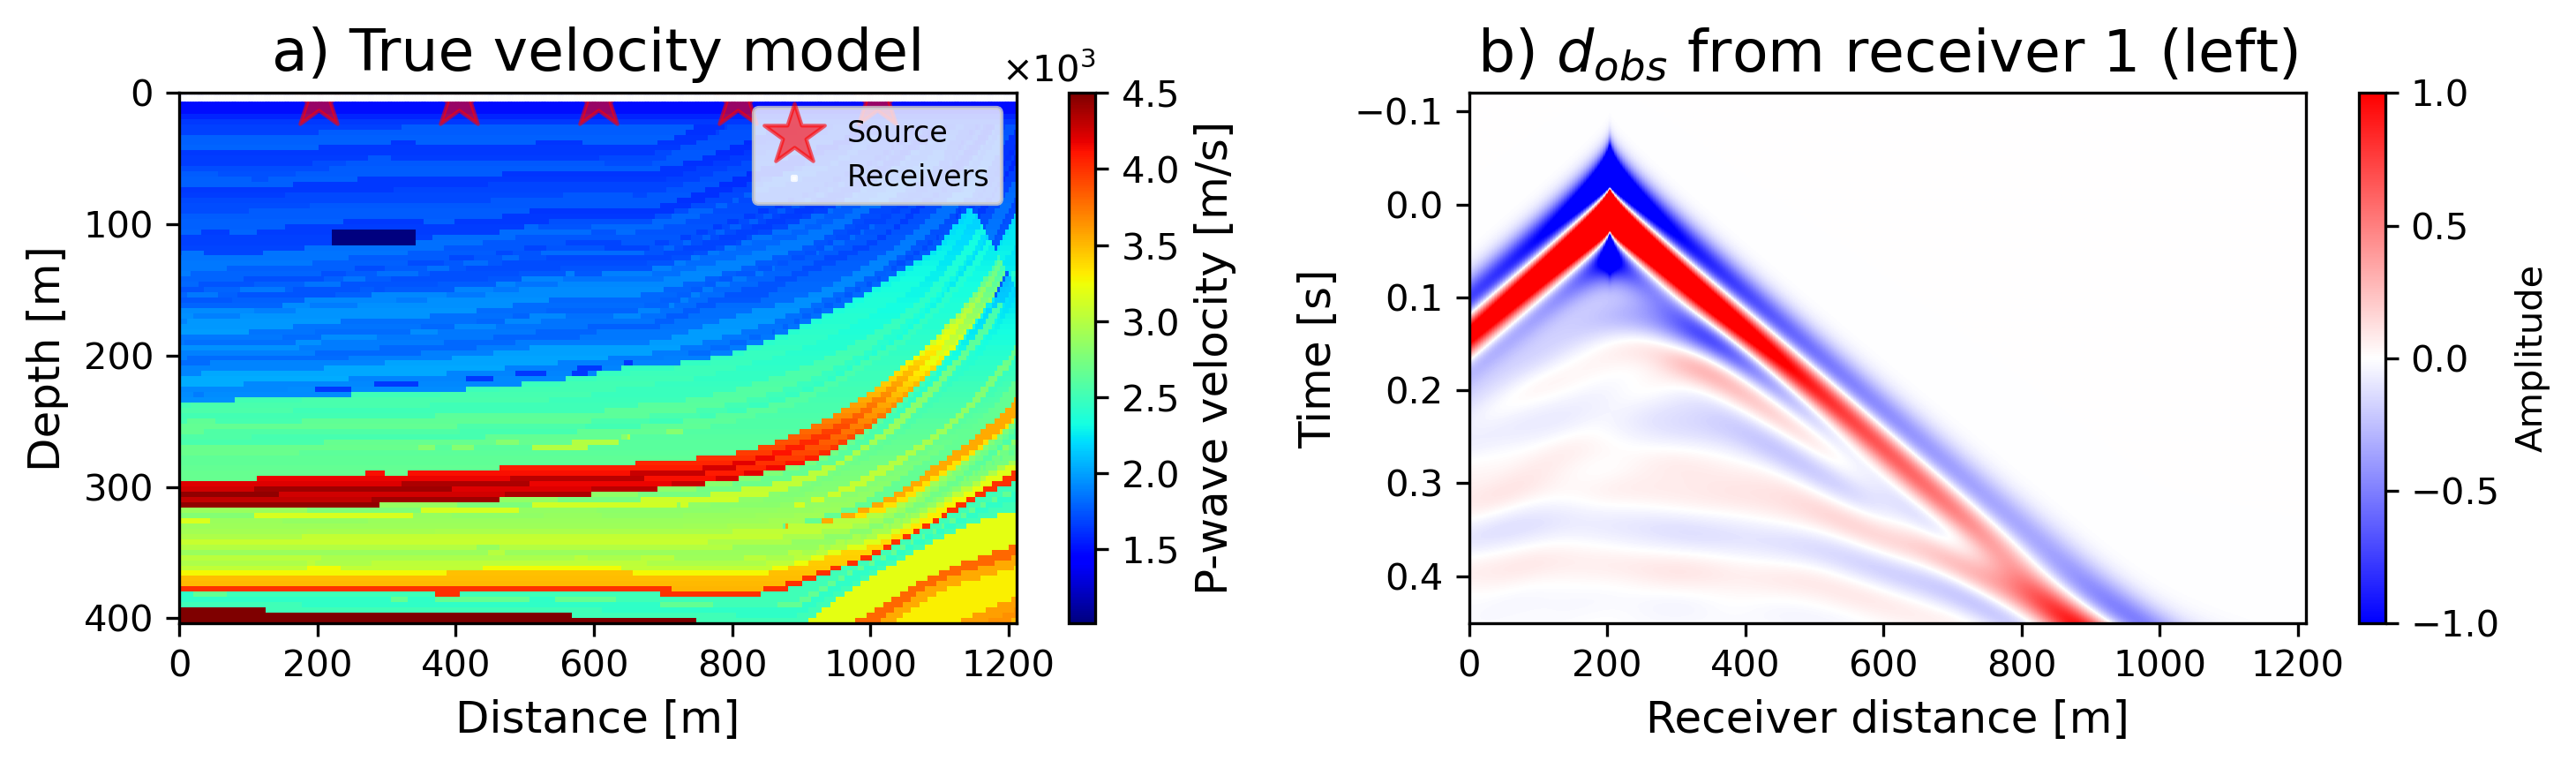

In [17]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from IPython.display import clear_output
import numpy as np
import cupy as cp
import cupyx
import scipy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import time
labelsize = 16

from func.propagation_matrix import defmodel, extend_model
from func.velocity_model import gaussian2d
from joblib import Parallel, delayed

precision = np.float64
device = 'cpu'

def receiver_position(setup):
  
  if setup==1:
    # Setup 1
    zxrec1 = np.vstack((np.full(len(receivers_width), zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(len(receivers_width), nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_height, np.full(len(receivers_height), zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_height, np.full(len(receivers_height), nx-zxsrc[0]-1))) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
    zxrec = zxrec1

  if setup==2:
    # Setup 2
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
    zxrec4 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==3:
    # Setup 3
    zxrec1 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, zxsrc[0])[len(receivers_width)//2:])) # Half Left
    zxrec4 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, nz-zxsrc[0]-1)[len(receivers_width)//2:])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==4:
    # Setup 4
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0])[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1)//2)) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  zxrec, indices = np.unique(zxrec,return_index=True,axis=1)

  return zxrec[:, np.argsort(indices)]


def extend_model(v,nz,nx,next):
	"""
	Extension of the model (to limit the edge effects)
	"""
	vel = v.reshape((nz,nx))
	nze  = nz + 2*next
	nxe  = nx + 2*next
	vele = np.zeros([nze,nxe], dtype=precision)
	# Central part
	vele[next:nze-next,next:nxe-next] = vel
	# Top and bottomB
	for ix in range(next,nxe-next):
		for iz in range(next):
			vele[iz,ix]       = vel[0,ix-next]
			vele[nze-1-iz,ix] = vel[nz-1,ix-next]
	# Left and right
	for ix in range(next):
		for iz in range(next,nze-next):
			vele[iz,ix]       = vel[iz-next,0]
			vele[iz,nxe-1-ix] = vel[iz-next,nx-1]
	# Corners
	for ix in range(next):
		for iz in range(next):
			vele[iz,ix]             = vel[0,0]
			vele[nze-1-iz,ix]       = vel[nz-1,0]
			vele[iz,nxe-1-ix]       = vel[0,nx-1]
			vele[nze-1-iz,nxe-1-ix] = vel[nz-1,nx-1]
	return vele.flatten()


def prop2d_cpu(wsrc, zxsrci, zxrec, vel, at, az, ax, next, device='cpu'):

	"""
	2d wave propagation with multiple sources
	"""
	
	if device=='cpu':
		"""
		2d wave propagation
		Resolution with finite differences
		Orders 2 in time and space
		with absorbing boundaries (Clayton and Engquist)
		Vectorial implementation (much faster)
		"""
		nabs  = 10
		next2 = nabs + next
		nt    = len(at)
		nz    = len(az)
		nx    = len(ax)
		dz    = az[1] - az[0]
		dx    = ax[1] - ax[0]
		dt    = at[1] - at[0]   
		_dz2   = 1./dz**2
		_dx2   = 1./dx**2

		nze = nz + 2 * next2
		nxe = nx + 2 * next2
		size = nze * nxe

		# Calculate source waveform
		wsrc = np.array([wsrc]) if wsrc.ndim == 1 else np.array(wsrc) # convert source wavelet from 1d to 2d
		zxsrci = np.array(zxsrci) # source location to array

		# Extend the model
		nze  = nz + 2*next2
		nxe  = nx + 2*next2
		vele = extend_model(vel,nz,nx,next2)
		vele = vele.flatten()

		# Center Part (Laplacian)
		mask0 = np.full((nze, nxe), False)
		mask0[1+nabs:-1-nabs,1+nabs:-1-nabs] = True
		mask0 = mask0.flatten()

		# Construct the Laplacian matrix
		fact = (dt * vele)**2

		# Initialize arrays
		diagonal = np.zeros(size)
		off_diagonal_x_left = np.zeros(size)
		off_diagonal_x_right = np.zeros(size)
		off_diagonal_z_left = np.zeros(size)
		off_diagonal_z_right = np.zeros(size)

		# Set values for interior points
		diagonal[mask0] = (2*np.ones(size) + fact*(-2*np.ones(size)*(_dz2+_dx2)))[mask0]
		off_diagonal_x_left[mask0] = (fact*np.ones(size) * _dz2)[mask0]
		off_diagonal_x_right[mask0] = (fact*np.ones(size) * _dz2)[mask0]
		off_diagonal_z_left[mask0] = (fact*np.ones(size) * _dx2)[mask0]
		off_diagonal_z_right[mask0] = (fact*np.ones(size) * _dx2)[mask0]

		# Calculate factors for boundary conditions
		factz = (-dt/dz) * vele
		factx = (-dt/dx) * vele

		# Bottom part
		mask1 = np.full((nze, nxe), False)
		mask1[nze-1-nabs:nze,:nxe] = True
		mask1 = mask1.flatten()
		diagonal[mask1] = 1 + factz[mask1]
		off_diagonal_z_left[mask1] = -factz[mask1]

		# Top part
		mask2 = np.full((nze, nxe), False)
		mask2[:1+nabs,:nxe] = True
		mask2 = mask2.flatten()
		diagonal[mask2] = 1 + factz[mask2]
		off_diagonal_z_right[mask2] = -factz[mask2]

		# Right part
		mask3 = np.full((nze, nxe), False)
		mask3[:nze,nxe-1-nabs:nxe] = True
		mask3 = mask3.flatten()
		diagonal[mask3] = 1 + factx[mask3]
		off_diagonal_x_left[mask3] = -factx[mask3]

		# Left part
		mask4 = np.full((nze, nxe), False)
		mask4[:nze,:1+nabs]  = True
		mask4 = mask4.flatten()
		diagonal[mask4] = 1 + factx[mask4]
		off_diagonal_x_right[mask4] = -factx[mask4]

		# Construct the sparse Laplacian matrix
		A = sp.diags([off_diagonal_x_left[1:], off_diagonal_z_left[nxe:], diagonal, off_diagonal_z_right, off_diagonal_x_right],
								[-1, -nxe, 0, nxe, 1], shape=(size, size), format='csr')

		# Wavefield p mask (initial center part)
		maskp = np.full((nze, nxe), 0)
		maskp[next+nabs:nze-next-nabs,next+nabs:nxe-next-nabs]  = 1
		maskp = maskp.flatten()

		pm = np.zeros(size) # Previous wave field
		pt = np.zeros(size)
		pp = np.zeros(size)

		p = [np.zeros(nz*nx)]
		p.append(np.zeros(nz*nx))

		srcsteps = wsrc.shape[1] # Determine the time steps of the source
		for it in range(1,nt-1): # From 1 to nt-1
			pm = pt.copy()
			pt = pp.copy()
			# pp = A.dot(pt) - pm*mask0 + pwsrc[:,it]*fact*mask0
			if it<srcsteps:
				cen = np.zeros((nz,nx))
				cen[zxsrci[0,:], zxsrci[1,:]] = wsrc[:,it]
				asrcit = np.pad(cen, next2, mode='constant').flatten()
				srcterm = asrcit*fact*mask0
			else: srcterm = np.zeros(size)

			pp = A.dot(pt) - pm*mask0 + srcterm
			p.append(pp[maskp==1])

		p = np.moveaxis(np.array(p), 0, -1)
		d_obs = p.reshape((nz,nx,nt))[zxrec[0], zxrec[1], :]

	return p, d_obs


def prop2d(wsrc, zxsrci, zxrec, vel, at, az, ax, next, device='cpu'):
	"""
	2d wave propagation with multiple sources
	"""
	
	if device=='cpu':
		"""
		2d wave propagation
		Resolution with finite differences
		Orders 2 in time and space
		with absorbing boundaries (Clayton and Engquist)
		Vectorial implementation (much faster)
		"""
		nabs  = 10
		next2 = nabs + next
		nt    = len(at)
		nz    = len(az)
		nx    = len(ax)
		dz    = az[1] - az[0]
		dx    = ax[1] - ax[0]
		dt    = at[1] - at[0]   
		_dz2   = 1./dz**2
		_dx2   = 1./dx**2

		nze = nz + 2 * next2
		nxe = nx + 2 * next2
		size = nze * nxe

		# Calculate source waveform
		wsrc = cp.array([wsrc]) if wsrc.ndim == 1 else cp.array(wsrc) # convert source wavelet from 1d to 2d
		zxsrci = cp.array(zxsrci) # source location to array

		# Extend the model
		nze  = nz + 2*next2
		nxe  = nx + 2*next2
		vele = extend_model(vel,nz,nx,next2)
		vele = cp.array(vele.flatten())

		# Center Part (Laplacian)
		mask0 = cp.full((nze, nxe), False)
		mask0[1+nabs:-1-nabs,1+nabs:-1-nabs] = True
		mask0 = mask0.flatten()

		# Construct the Laplacian matrix
		fact = (dt * vele)**2

		# Initialize arrays
		diagonal = cp.zeros(size)
		off_diagonal_x_left = cp.zeros(size)
		off_diagonal_x_right = cp.zeros(size)
		off_diagonal_z_left = cp.zeros(size)
		off_diagonal_z_right = cp.zeros(size)

		# Set values for interior points
		diagonal[mask0] = (2*cp.ones(size) + fact*(-2*cp.ones(size)*(_dz2+_dx2)))[mask0]
		off_diagonal_x_left[mask0] = (fact*cp.ones(size) * _dz2)[mask0]
		off_diagonal_x_right[mask0] = (fact*cp.ones(size) * _dz2)[mask0]
		off_diagonal_z_left[mask0] = (fact*cp.ones(size) * _dx2)[mask0]
		off_diagonal_z_right[mask0] = (fact*cp.ones(size) * _dx2)[mask0]

		# Calculate factors for boundary conditions
		factz = (-dt/dz) * vele
		factx = (-dt/dx) * vele

		# Bottom part
		mask1 = cp.full((nze, nxe), False)
		mask1[nze-1-nabs:nze,:nxe] = True
		mask1 = mask1.flatten()
		diagonal[mask1] = 1 + factz[mask1]
		off_diagonal_z_left[mask1] = -factz[mask1]

		# Top part
		mask2 = cp.full((nze, nxe), False)
		mask2[:1+nabs,:nxe] = True
		mask2 = mask2.flatten()
		diagonal[mask2] = 1 + factz[mask2]
		off_diagonal_z_right[mask2] = -factz[mask2]

		# Right part
		mask3 = cp.full((nze, nxe), False)
		mask3[:nze,nxe-1-nabs:nxe] = True
		mask3 = mask3.flatten()
		diagonal[mask3] = 1 + factx[mask3]
		off_diagonal_x_left[mask3] = -factx[mask3]

		# Left part
		mask4 = cp.full((nze, nxe), False)
		mask4[:nze,:1+nabs]  = True
		mask4 = mask4.flatten()
		diagonal[mask4] = 1 + factx[mask4]
		off_diagonal_x_right[mask4] = -factx[mask4]

		# Construct the sparse Laplacian matrix
		# A = sp.diags([off_diagonal_x_left[1:], off_diagonal_z_left[nxe:], diagonal, off_diagonal_z_right, off_diagonal_x_right],
		# 						[-1, -nxe, 0, nxe, 1], shape=(size, size), format='csr')
		
		A = cupyx.scipy.sparse.diags([off_diagonal_x_left[1:], off_diagonal_z_left[nxe:], diagonal, off_diagonal_z_right, off_diagonal_x_right],
								[-1, -nxe, 0, nxe, 1], shape=(size, size), format='csr')
		
		# Wavefield p mask (initial center part)
		maskp = cp.full((nze, nxe), 0)
		maskp[next+nabs:nze-next-nabs,next+nabs:nxe-next-nabs]  = 1
		maskp = maskp.flatten()

		pm = cp.zeros(size) # Previous wave field
		pt = cp.zeros(size)
		pp = cp.zeros(size)

		p = [cp.zeros(nz*nx)]
		p.append(cp.zeros(nz*nx))

		srcsteps = wsrc.shape[1] # Determine the time steps of the source
		for it in range(1,nt-1): # From 1 to nt-1
			pm = pt.copy()
			pt = pp.copy()
			# pp = A.dot(pt) - pm*mask0 + pwsrc[:,it]*fact*mask0
			if it<srcsteps:
				cen = cp.zeros((nz,nx))
				cen[zxsrci[0,:], zxsrci[1,:]] = wsrc[:,it]
				asrcit = cp.pad(cen, next2, mode='constant').flatten()
				srcterm = asrcit*fact*mask0
			else: srcterm = cp.zeros(size)

			pp = A.dot(pt) - pm*mask0 + srcterm
			p.append(pp[maskp==1])

		p = cp.moveaxis(cp.array(p), 0, -1)
		d_obs = p.reshape((nz,nx,nt))[zxrec[0], zxrec[1], :]

	return cp.asnumpy(p), cp.asnumpy(d_obs)

def second_order_derivative(p, at, az, ax):
	"""
	Calculate second order derivative for p(z,x,t)
	method: finite-difference
	"""
	# extend model to tmin=0 tmax=0 -- insert zeros in dimension t
	nz, nx = len(az), len(ax)
	dt = at[1] - at[0]
	# Modify p array in-place without copying
	p = cp.array(p)
	p[:, 0] = 0.0
	p[:, -1] = 0.0
	_dt2 = 1./dt**2
	# Calculate second order derivative using vectorized operations
	p_dt_dt = (p[:, :-2] - 2 * p[:, 1:-1] + p[:, 2:]) * _dt2
	# Insert zeros at boundaries using array views
	p_dt_dt = cp.concatenate([cp.zeros((nz*nx, 1)), p_dt_dt, cp.zeros((nz*nx, 1))], axis=1)

	return cp.asnumpy(p_dt_dt)

def second_order_derivative_cpu(p, at, az, ax):
	"""
	Calculate second order derivative for p(z,x,t)
	method: finite-difference
	"""
	# extend model to tmin=0 tmax=0 -- insert zeros in dimension t
	nz, nx = len(az), len(ax)
	dt = at[1] - at[0]
	# Modify p array in-place without copying
	p[:, 0] = 0.0
	p[:, -1] = 0.0
	_dt2 = 1./dt**2
	# Calculate second order derivative using vectorized operations
	p_dt_dt = (p[:, :-2] - 2 * p[:, 1:-1] + p[:, 2:]) * _dt2
	# Insert zeros at boundaries using array views
	p_dt_dt = np.concatenate([np.zeros((nz*nx, 1)), p_dt_dt, np.zeros((nz*nx, 1))], axis=1)

	return p_dt_dt

def J(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	nz, nx = len(az), len(ax)
	if vel.ndim == 1: vel = np.reshape(vel.flatten(),(nz,nx))
	_, d = prop2d(wsrc,zxsrc,zxrec,vel,at,az,ax,next,device)
	residual = d - d_obs
	J = 0.5 * np.sum(residual ** 2) # Residual is the half of the L2 norm square
	print("J = %.2f" % J)
	global loss
	loss = J.copy()

	return J

def gradient(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	"""
	Calculate gradiant using adjoint state method
	"""
	p_fwd, d = prop2d(wsrc,zxsrc,zxrec,vel,at,az,ax,next,device)
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back, _ = prop2d(np.flip(residual,axis=1), zxrec, zxsrc, vel, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=1)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative_cpu(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/vel**3  * np.sum(p_back * p_dt_dt, axis=1) # G.shape = (201,201)
	
	return G.flatten()

def gradient_multi(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	"""
	Calculate gradiant using adjoint state method
	"""
	nsrc = zxsrc.shape[1]
	grads = np.zeros_like(vel)
	for i in range(nsrc):
		print('Source', i, end='...   ')
		zxsrci = np.expand_dims(zxsrc[:,i],-1)
		p_fwd, d = prop2d(wsrc,zxsrci,zxrec,vel,at,az,ax,next,device)
		residual = d - d_obs[i] # residual shape (n_rec, nt) - residual.shape=(5,801)
		# Calculate back propagated p_back(z,x,t)
		p_back, _ = prop2d(np.flip(residual,axis=1), zxrec, zxsrci, vel, at, az, ax, next, device)
		p_back = np.flip(p_back,axis=1)
		# Calculate second order time derivative of p_fwd(z,x,t)
		p_dt_dt = second_order_derivative_cpu(p_fwd, at, az, ax)
		# Calculate gradiant
		grad = 2/vel**3  * np.sum(p_back * p_dt_dt, axis=1) # G.shape same as vel
		grads += grad

	return grads.flatten()

def gradient_par(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	nsrc = zxsrc.shape[1]
	grads = Parallel(n_jobs=nsrc)(delayed(gradient)
			       (vel,d_obs,wsrc,np.expand_dims(zxsrc[:,i],-1),zxrec,at,az,ax,next,device) 
			        for i in range(nsrc))
	
	return sum(grads).flatten()

def readbin(flnam,nz,nx):
    # Read binary file (32 bits)
    with open(flnam,"rb") as fl:
        im = np.fromfile(fl, dtype=np.float32)
    im = im.reshape(nz,nx,order='F')
    return im

# Initialize the model axis az, ax, at
nz,nx,nt = 101,301,1000
vmin,vmax = 1000,4500
izsrc, ixsrc = [1], [300]
next = 100

# Read the original input data
vel   = readbin('../dataset/marm2_sel.dat',201,601)
vel = vel[::2,::2]
vel[26:29,55:85] = 1.01
v_ref = vel * 1e3
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

# v_ref, Q = gaussian2d(ranges = [50,600], param=1.,nx=[nz,nx], variance=500, mu=2750)
v_init = 2750 * np.ones(nz*nx)
vmin,vmax = v_ref.min(),v_ref.max()

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
# receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
# 							np.arange(zxsrc[1][0],nx,interv)) #right
receivers_width = np.arange(0,nx)
receivers_height = np.arange(izsrc[0],nz-izsrc[0],interv) # down
zxrec = receiver_position(1)

zxsrc = np.array([[1,1,1,1,1], [nx//6,2*nx//6,3*nx//6,4*nx//6,5*nx//6]])
# zxsrc = np.array([[1], [3*nx//6]])
nsrc = zxsrc.shape[1]
d_obs = []
for i in range(nsrc):
	zxsrci = np.expand_dims(zxsrc[:,i],-1)
	p, d_obs_i = prop2d(wsrc,zxsrci,zxrec,v_ref.reshape(nz,nx),at,az,ax,next,device)
	d_obs.append(d_obs_i)

plt.figure(figsize=(10,3), dpi=300)
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
cbar = plt.colorbar()
cbar.formatter.set_useMathText(True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
cbar.update_ticks()
cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
plt.legend(loc='upper right',fontsize=labelsize-8)
plt.xlabel('Distance [m]', fontsize=labelsize-4)
plt.ylabel('Depth [m]', fontsize=labelsize-4)
plt.title("a) True velocity model",fontsize=labelsize)

plt.subplot(1,2,2)
plt.imshow(d_obs[0].T,cmap='bwr',vmin=-1,vmax=1,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
cbar = plt.colorbar()
cbar.set_label("Amplitude")
plt.title("b) $d_{obs}$ from receiver 1 (left)", fontsize=labelsize)
plt.xlabel('Receiver distance [m]', fontsize=labelsize-4)
plt.ylabel('Time [s]', fontsize=labelsize-4)
plt.tight_layout()
plt.show()

## Inversion with prior regularization term

In [ ]:
from func.velocity_model import gaussian2d

# Modified FWI objective function with regularization
def J_prior(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	nsrc = zxsrc.shape[1]
	Js = 0
	for i in range(nsrc):
			zxsrci = np.expand_dims(zxsrc[:,i],-1)
			nz, nx = len(az), len(ax)
			if vel.ndim == 1: vel = np.reshape(vel.flatten(),(nz,nx))
			_, d = prop2d(wsrc,zxsrci,zxrec,vel,at,az,ax,next,device)
			residual = d - d_obs[i]
			J = 0.5 * np.sum(residual ** 2) # Residual is the half of the L2 norm square
			Js += J
	print("Loss (J) = %.4f " % Js, end='')
	vel = vel.flatten()
	# penalty = .5 * vel.T.dot(Q.toarray()).dot(vel)
	penalty = 0.5 * (vel-mu).T.dot(Q.dot(vel-mu)) * alpha**2
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = Js + penalty
	print("Total loss = %.4f " % loss)
	# Save history
	global current_loss
	current_loss = np.array([loss,Js,penalty])

	return loss

# Modified FWI gradient with regularization
def gradient_prior(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# grad = gradient_par(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
	nsrc = zxsrc.shape[1]
	grad = gradient_multi(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)

	return grad.flatten() + Q.dot(vel.flatten()-mu) * alpha**2

# Record loss history over each iterations
def callback(x):
	global loss_tracker
	loss_tracker = np.vstack([loss_tracker,current_loss])
	clear_output(wait=True)

	plt.figure(figsize=(10,6), dpi=300)
	# Plot the true velocity
	plt.subplot(221)
	plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.formatter.set_useMathText(True)
	cbar.formatter.set_scientific(True)
	cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
	cbar.update_ticks()
	cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
	plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
	plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
	plt.legend(loc='upper right',fontsize=labelsize-8)
	plt.xlabel('Distance [m]', fontsize=labelsize-4)
	plt.ylabel('Depth [m]', fontsize=labelsize-4)
	plt.title("(a) True velocity model",fontsize=labelsize)

	# Plot the initial velocity
	plt.subplot(222)
	plt.imshow(v_init.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.formatter.set_useMathText(True)
	cbar.formatter.set_scientific(True)
	cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
	cbar.update_ticks()
	cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
	plt.xlabel('Distance [m]', fontsize=labelsize-4)
	plt.ylabel('Depth [m]', fontsize=labelsize-4)
	plt.title("(b) Initial velocity model",fontsize=labelsize)

	# Display current velocity field
	plt.subplot(223)
	plt.imshow(x.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.formatter.set_useMathText(True)
	cbar.formatter.set_scientific(True)
	cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
	cbar.update_ticks()
	cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
	plt.xlabel('Distance [m]', fontsize=labelsize-4)
	plt.ylabel('Depth [m]', fontsize=labelsize-4)
	plt.title("(c) FWI result (with prior)",fontsize=labelsize)

	# Display loss track
	plt.subplot(224)
	plt.plot(loss_tracker,lw=1.5)
	plt.legend(['Total loss','Data misfit','Prior penalty'])
	# Set the x-axis tick formatter to scientific notation
	formatter = ScalarFormatter(useMathText=True)
	formatter.set_scientific(True)
	formatter.set_powerlimits((-2,2))  # Adjust these limits as needed
	plt.gca().yaxis.set_major_formatter(formatter)
	plt.legend(['Data misfit'])
	plt.xlim(xmin=0)
	plt.ylim(ymin=0)
	plt.xlabel('Epoch', fontsize=labelsize-4)
	plt.ylabel('Loss', fontsize=labelsize-4)
	plt.title("(d) Optimization history",fontsize=labelsize)

	plt.tight_layout()
	plt.show()


from scipy.optimize import minimize
# minimize cost function
simu, Q = gaussian2d(ranges = [10,600], param=1.,nx=[nz,nx], variance=900, mu=(vmin+vmax)/2)
v_smo = readbin('../dataset/marm2_smo.dat',201,601)
v_smo = v_smo[::2,::2]
v_init = (v_smo * 1e3).flatten()
mu = v_init
loss_tracker = np.empty((0,3))

std_noise = 0.001 # define the noise level

resi = minimize(fun = J_prior, 
               x0 = v_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise),
               method='L-BFGS-B', 
               # method='Newton-CG',
               bounds = np.full((len(v_init.flatten()), 2), (vmin,vmax)),
               jac = gradient_prior,
               options = {'disp':True, 'maxiter':500},
               callback=callback
              )
v_fwi = resi.x

plt.imshow(v_fwi.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet')

# SVGD

In [29]:
import tensorflow as tf
import tensorflow_probability as tfp
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import pairwise_distances
from sksparse.cholmod import cholesky

def display_particles(q_particles, q_mean, q_std, save_figure=False):
  plt.figure(figsize=(10,8), dpi=300)
  plt.suptitle("$\sigma_{Noise}=$%.2f  " % std_noise + \
              "    $N_{particles}=$"+str(num_particles)+
              "     $h=%.2f$" % h,
              fontsize=labelsize+8)

  plt.subplot(3,2,1)
  plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
  plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
  plt.legend(loc='upper right',fontsize=labelsize-8)
  plt.xlabel('Distance [m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("(a) $v_{True}$", fontsize=16)

  plt.subplot(3,2,2)
  plt.imshow(tf.reshape(q_mean,[nz,nx]),vmin=vmin,vmax=vmax,
             cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
  plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
  plt.legend(loc='upper right',fontsize=labelsize-8)
  plt.xlabel('Distance [m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("Posterior Mean $\mu_{q}$", fontsize=16)

  plt.subplot(3,2,3)
  # plt.imshow(tf.reshape(tfp.stats.stddev(q_particles),[nz,nx]),cmap='Reds')
  plt.imshow(tf.reshape(q_std,[nz,nx]),cmap='Reds',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  plt.colorbar()
  plt.title("Posterior Uncertainty $\sigma_{q}$", fontsize=16)

  plt.subplot(3,2,4)
  plt.imshow(tf.reshape(q_mean_prior,[nz,nx]),vmin=vmin,vmax=vmax,
             cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
  plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
  plt.legend(loc='upper right',fontsize=labelsize-8)
  plt.xlabel('Distance [m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("Prior Mean $\mu_{p}$", fontsize=16)

  plt.subplot(3,2,5)
  plt.imshow(tf.reshape(q_particles[0,:],[nz,nx]),vmin=vmin,vmax=vmax,
             cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
  plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
  plt.legend(loc='upper right',fontsize=labelsize-8)
  plt.xlabel('Distance [m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("Partical $q_j$", fontsize=16)

  plt.subplot(3,2,6)
  plt.plot(misfit_history, label='Data misfit J', lw=3)
  plt.legend(['Data misfit'])
  plt.xlim(xmin=0)
  # plt.ylim(ymin=0)
  plt.title("Training history", fontsize=16)
  plt.legend(fontsize=16)

  plt.tight_layout()
  # plt.show()
  if save_figure==True:
    if f'gif_{idx:02d}' not in os.listdir('./img/SVGD/'):
      os.system(f'mkdir ./img/SVGD/gif_{idx:02d}')
    plt.savefig(f'./img/SVGD/gif_{idx:02d}/img_{i}.png', 
                  transparent = False,  
                  facecolor = 'white'
                )
  plt.show()
  plt.close()

def sample_from_Qmat(Qmat, num_samples,mu):

  factor = cholesky(Qmat)
  # Generate independent standard normal random variables
  u = np.random.standard_normal((Qmat.shape[0], num_samples))
  # Apply Cholesky factorization operations and permutation
  samples = factor.apply_Pt(factor.solve_DLt(u))+mu.reshape((nz*nx,1))
  return np.swapaxes(samples,0,1)

def compute_gradient(q):
    # Compute log posterior probability (negative gradient)
    return -gradient_prior(q.numpy(),*args)
    # return tf.cast(gradiant_fwi_prior(u.numpy(),d_obs,*args), tf.float32)

def compute_parallel(q_particles, num_jobs=4):
    grads_log_prob = Parallel(n_jobs=num_jobs)(delayed(compute_gradient)(q) for q in q_particles)
    return grads_log_prob

# Define the TensorFlow variables for the variational posterior particles
num_particles = 10
N = tf.cast(num_particles, dtype=tf.float32)
simu, Q = gaussian2d(ranges = [10,600], param=1.,nx=[nz,nx], variance=300, mu=(vmin+vmax)/2)
q_particles = tf.Variable(sample_from_Qmat(Q, num_particles, mu), dtype=tf.float32)
q_mean = tf.reduce_mean(q_particles, axis=0)
q_mean_prior = tf.identity(q_mean)

# Set up lists to store progress
misfit_history = []
misfit = J_prior(q_mean_prior.numpy(),*args)

Loss (J) = 26102.1130 Penalty term = 0.0000 Total loss = 26102.1130 


In [30]:
# ===============================================================================================
# Set hyper-parameters
stepsize = 10
std_noise = 1e-4
historical_grad = 0
w = 0.9 # Weight on adagrad momentum
args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise)

# Train the variational posterior using the ELBO objective
num_iters = 5000

for i in range(num_iters):
    # Print the iteration number
    print(f"Iteration {i + 1}/{num_iters}", end="    ")
    J_prior(q_mean.numpy(),*args)
    print(misfit_history)
    if i>1: print("J = %.2f" % misfit_history[-1])
    print(f"Step size: {stepsize}")
    # Compute the SVGD kernel matrix and its gradient  Cost: O(n^2)
    with tf.GradientTape() as tape:
      tape.watch(q_particles)
      # Compute pairwise distances between all the current particles
      med = np.median(pairwise_distances(q_particles))
      # h = med**2/np.log(num_particles)  # Set bandwidth parameter h to be med^2 / log(n)
      h = med/np.sqrt(2*np.log(num_particles))

      rbf_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=float(h))
      with tape.stop_recording(): q_particles_ = tf.identity(q_particles)
      svgd_kernel_matrix = rbf_kernel.matrix(q_particles, q_particles_)
      grads_kernal_matrix = tape.gradient(svgd_kernel_matrix, q_particles)
      print(tf.reduce_sum(svgd_kernel_matrix[0,:]).numpy())

    q_mean = tf.reduce_mean(q_particles, axis=0)
    q_std = tfp.stats.stddev(q_particles)

    # Compute the log(d_obs|v) log-likelihood and its gradient
    log_likelihoods = []
    grads_log_likelihoods = []
    
    # Calculate the gradient of the log-likelihoods
    grads_log_prob = []
    for q in q_particles: grads_log_prob.append(-gradient_prior(q.numpy(),*args))
    # grads_log_prob = compute_parallel(q_particles, 2) # Compute gradient in parrallel

    # Compute the SVGD gradient for each particle
    grad_svgd = 1/q_particles.shape[0]*(tf.matmul(svgd_kernel_matrix, tf.cast(grads_log_prob,tf.float32)) \
                                          + grads_kernal_matrix)
    # grad_svgd = tf.tile(tf.expand_dims(tf.reduce_sum(grad_svgd, axis=0),0), [num_particles,1]) # Repeat gradient
    
    # Backup particles and gradient
    q_particles_backup = tf.identity(q_particles)
    historical_grad_backup = tf.identity(historical_grad)

    # AdaGrad
    if i == 0:
        historical_grad = historical_grad + grad_svgd ** 2
    else:
        historical_grad = w * historical_grad + (1 - w) * (grad_svgd ** 2)
    ada_grad = np.divide(grad_svgd, 1e-6+np.sqrt(historical_grad))
    q_particles = q_particles + stepsize * ada_grad # Apply the SVGD update to the particles
    # q_particles = q_particles + stepsize * update_svgd

    # Calculate misfit
    misfit = J_prior(q_mean.numpy(),*args)
    misfit_history.append(misfit)

    #AdaStep
    if len(misfit_history)<=1: stepsize = stepsize*1
    elif misfit_history[-1] >= misfit_history[-2]: 
       q_particles = q_particles_backup
       stepsize = stepsize/10
       misfit_history.pop()
       historical_grad = historical_grad_backup
    # else: stepsize=stepsize*1.1
       
    clear_output(wait=True)
    display_particles(q_particles, q_mean, q_std, save_figure=False)



Iteration 1/5000    Loss (J) = 26102.1130 Penalty term = 0.0000 Total loss = 26102.1130 
[]
Step size: 10
2.083118
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Source 0...   Source 1...   Source 2...   

In [ ]:
def display_particles(q_particles, q_mean, q_std, save_figure=False):
  plt.figure(figsize=(10,8), dpi=300)
  plt.suptitle("$\sigma_{Noise}=$%.2f  " % std_noise + \
              "    $N_{particles}=$"+str(num_particles)+
              "     $h=%.2f$" % h,
              fontsize=labelsize+8)

  plt.subplot(3,2,1)
  plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
  plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
  plt.legend(loc='upper right',fontsize=labelsize-8)
  plt.xlabel('Distance [m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("(a) $v_{\text{True}}$", fontsize=16)

  plt.subplot(3,2,2)
  plt.imshow(tf.reshape(q_mean,[nz,nx]),vmin=vmin,vmax=vmax,
             cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
  plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
  plt.legend(loc='upper right',fontsize=labelsize-8)
  plt.xlabel('Distance [m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("Posterior Mean $f(\mu_{X} \sim q(u))$", fontsize=16)

  plt.subplot(3,2,3)
  # plt.imshow(tf.reshape(tfp.stats.stddev(q_particles),[nz,nx]),cmap='Reds')
  plt.imshow(tf.reshape(q_std,[nz,nx]),cmap='Reds',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  plt.colorbar()
  plt.title("Posterior Uncertainties $\sigma_{q}(u)$", fontsize=16)

  plt.subplot(3,2,4)
  plt.imshow(q_std,cmap='Reds')
  plt.colorbar()
  plt.title("Prior Uncertainties $\sigma_{p}(u)$", fontsize=16)

  plt.subplot(3,2,(5,6))
  plt.plot(misfit_history, label='Data misfit J', lw=3)
  plt.xlim(0, 500*(len(misfit_history)//500+1))
  plt.ylim(bottom=0)
  plt.title("Training history", fontsize=16)
  plt.legend(fontsize=16)

  plt.tight_layout()
  # plt.show()
  if save_figure==True:
    if f'gif_{idx:02d}' not in os.listdir('./img/SVGD/'):
      os.system(f'mkdir ./img/SVGD/gif_{idx:02d}')
    plt.savefig(f'./img/SVGD/gif_{idx:02d}/img_{i}.png', 
                  transparent = False,  
                  facecolor = 'white'
                )
  plt.show()
  plt.close()

display_particles(q_particles, q_mean, q_std, save_figure=False)